In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nafflib


def cauchy(x,loc,scale):
    # from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.cauchy.html
    return 1/(np.pi*scale*(1+((x-loc)/scale)**2))


def dense_spectrum(Q0,param):
    # Creating dummy signal with dense spectral lines
    #==============================================
    N  = np.arange(int(1e5))
    Q0 = 0.31025793875089835
    Qs = 0.002
    dQ = Qs/param
    Jx = (0.5*(10**2))

    n_bands_Qs = 1
    n_bands_dQ = 5
    i,j    = np.arange(-n_bands_dQ,n_bands_dQ+1),np.arange(-n_bands_Qs,n_bands_Qs+1)
    Ai,Aj  = cauchy(i/np.max(i),0,0.05),cauchy(j/np.max(j),0,0.05)
    Ai,Aj  = Ai/np.max(Ai),Aj/np.max(Aj)

    amplitudes  = np.array([[ (np.sqrt(2*Jx)*_Ai*_Aj) for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten()
    frequencies = np.array([[Q0+ _j*Qs + _i*dQ for _i,_Ai in zip(i,Ai) ] for _j,_Aj in zip(j,Aj) ]).flatten() 

    Q_vec = [Q0,Qs,dQ]

    return amplitudes,frequencies,Q_vec,nafflib.generate_signal(amplitudes,frequencies,N)
    #==============================================

def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(len(x))

    # Cropping signal to closest power of 2
    Nt      = len(x)
    crop_at = 2**int(np.log2(Nt))



    
    spectrum = np.fft.fft(x[:crop_at])
    freq     = np.fft.fftfreq(turns[:crop_at].shape[-1])

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]




---
# Applying nafflib to dense spectrum
---

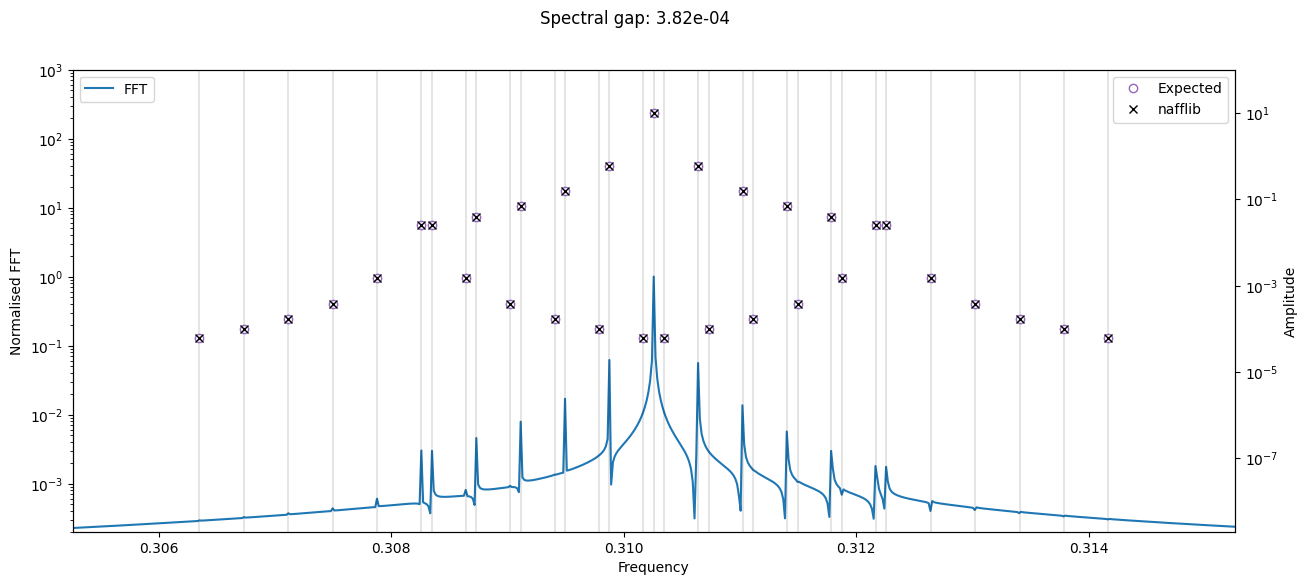

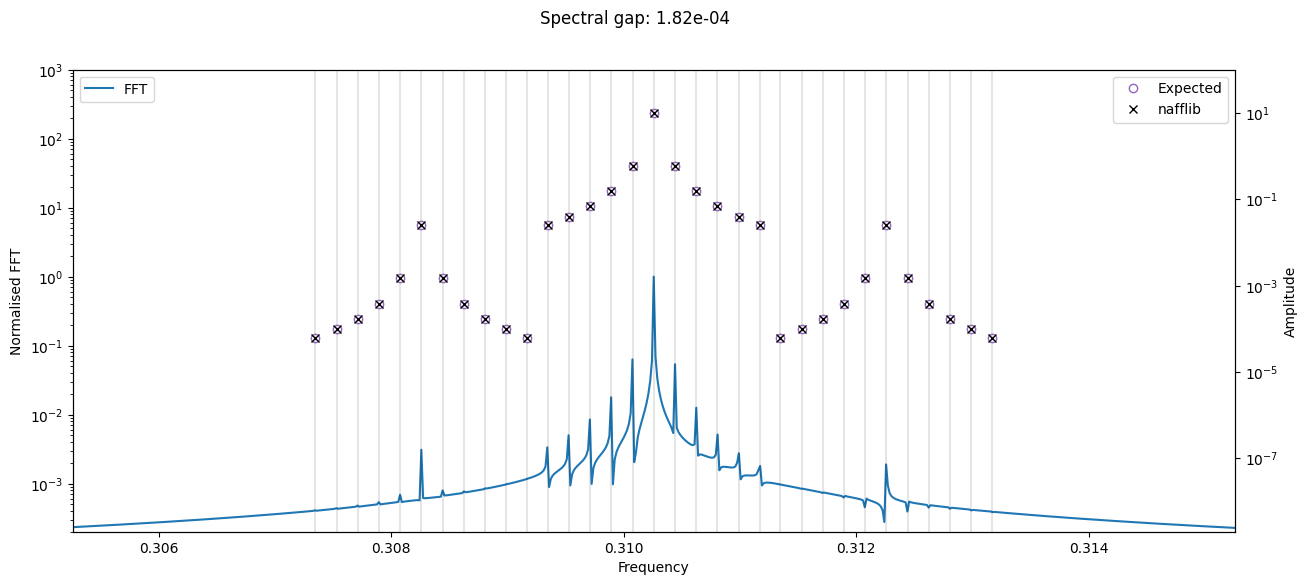

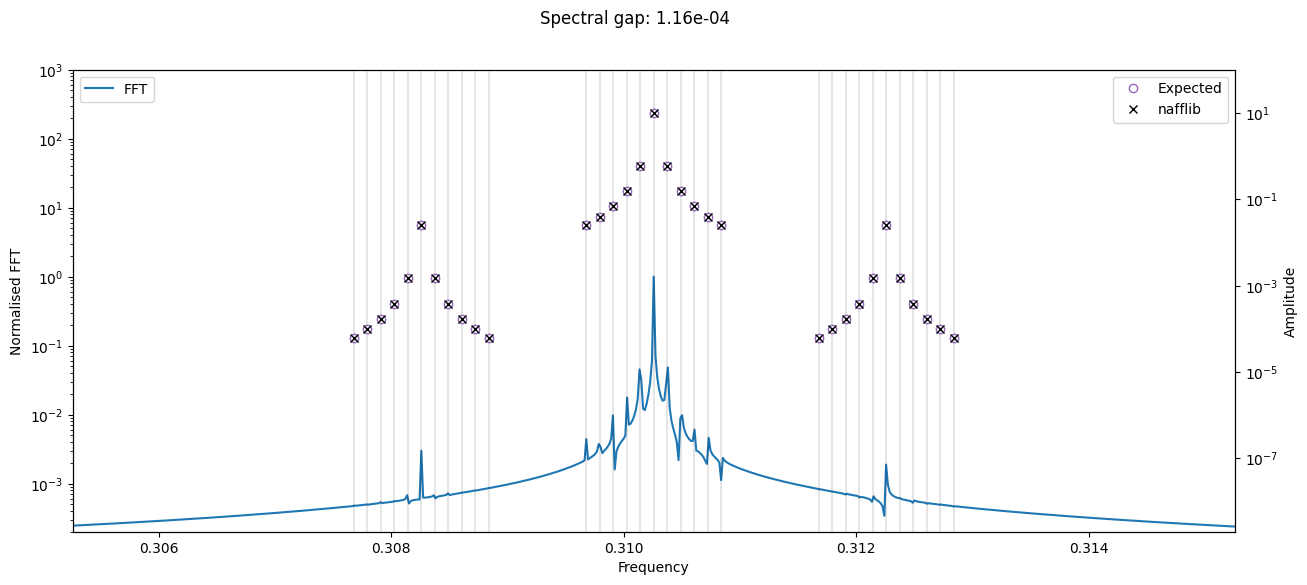

In [2]:

#-----
# Dummy signal main frequency
Q0 = 0.31025793875089835
#-----
example_signals = {}
for num,label in zip([1,2,3],['param_1','param_2','param_3']):
    # set of irrationnal numbers for spectrum spacing
    param = 5*num*(np.pi/3)**num
    A,Q,Q_vec,signal = dense_spectrum(Q0,param)
    example_signals[label] = signal
    example_signals[f'{label}:A'] = A
    example_signals[f'{label}:Q'] = Q
    example_signals[f'{label}:Q_vec'] = Q_vec



# Plotting
#==============================================
for num,label in zip([1,2,3],['param_1','param_2','param_3']):

    # Extracting signal
    x,px = example_signals[label]
    Q,A  = example_signals[f'{label}:Q'],example_signals[f'{label}:A']

    z    = x - 1j*px
    N    = np.arange(len(z))


    # Computing FFT
    freq,spectrum = get_FFT(x)

    # Computing frequencies and amplitudes with SUSSIX
    #=================================================
    results = nafflib.harmonics( x, px, num_harmonics = len(Q),window_order = 2,to_pandas=True)
    #=================================================

    Qs = 0.002
    param = 5*num*(np.pi/3)**num
    dQ = Qs/param

    plt.figure(figsize=(15,6))
    plt.suptitle(f'Spectral gap: {dQ:.2e}')
    plt.plot(freq,spectrum/np.max(spectrum),'-',label='FFT')
    plt.yscale('log')
    plt.xlabel('Frequency')
    plt.ylabel('Normalised FFT')
    plt.legend(loc='upper left')
    plt.ylim(2e-4,1e3)


    ax2 = plt.gca().twinx()
    plt.plot(Q,A,'o',color='C4',alpha=1,mfc='none',label='Expected')
    plt.plot(results.frequency,np.abs(results.amplitude),'x',color='k',alpha=1,mfc='none',label='nafflib')

    plt.yscale('log')
    plt.ylabel('Amplitude')

    
    plt.xlim(Q0-30*(Qs/12),Q0+30*(Qs/12))

    for line in Q:
        plt.axvline(line,color='k',alpha=0.1,zorder=-10)

    plt.ylim(2e-9,1e2)

    plt.legend(loc='upper right')

---
# About frequency sorting
---

In [3]:
# One should be careful to find a unique identifier for each line! This can be done 
# by finding the linear combinations of the fundamental tunes, for the case of quasi-periodic motion

# Showing that the lines are not sorted in the same order:
for num,label in zip([1,2,3],['param_1','param_2','param_3']):

    # Extracting signal
    fundamental_tunes = [Q0,]
    x,px = example_signals[label]
    A,Q,Q_vec  = example_signals[f'{label}:A'],example_signals[f'{label}:Q'],example_signals[f'{label}:Q_vec']
    
    # nafflib
    A_found,Q_found = nafflib.harmonics(x,px,num_harmonics = len(Q),window_order = 2,window_type = 'hann')

    print(20*'-' + f' {label} ' + 20*'-')
    print(f'Line-by-line comparison: Q_err = {np.max(np.abs(Q-Q_found)):.5e}')

    # Sorting lines and compiling errors
    #-----------------------------------
    r,_,_ = nafflib.find_linear_combinations(Q,fundamental_tunes= Q_vec)
    r_found,_,_ = nafflib.find_linear_combinations(Q_found,fundamental_tunes= Q_vec)

    errors_Q = []
    errors_A = []
    for res,_A,_Q in zip(r,A,Q):
        found_idx = r_found.index(res)
        errors_Q.append(Q_found[found_idx]-_Q)
        errors_A.append(np.abs(A_found[found_idx])-np.abs(_A))
    #-----------------------------------
        
    print(f'sorted line comparison : Q_err = {np.max(errors_Q):.5e}')
        

-------------------- param_1 --------------------
Line-by-line comparison: Q_err = 7.43775e-03
sorted line comparison : Q_err = 8.97063e-10
-------------------- param_2 --------------------
Line-by-line comparison: Q_err = 5.45903e-03
sorted line comparison : Q_err = 8.08603e-12
-------------------- param_3 --------------------
Line-by-line comparison: Q_err = 4.92884e-03
sorted line comparison : Q_err = 2.55648e-11
